In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%pip install tensorflow
%pip install tensorflow-hub
%pip install --upgrade tensorflow_hub
%pip install pydotplus
%pip install pydot
%pip install keras


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.16.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-macosx_10_9_universal2.whl.metadata (21 kB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
Using cached absl_py-2.3.0-py3-none-any.whl (135 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 23

In [3]:
import pandas as pd
import numpy as np
from time import time
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from tensorflow import keras
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from keras.regularizers import l2
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers



import pydotplus as pyd

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

ImportError: cannot import name 'clip_to_image_size' from 'keras.src.layers.preprocessing.image_preprocessing.bounding_boxes.converters' (/opt/anaconda3/envs/ling111/lib/python3.12/site-packages/keras/src/layers/preprocessing/image_preprocessing/bounding_boxes/converters.py)

In [1]:
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"), protocol=4)

def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [28]:
train = pd.read_csv('train_clean.csv')
cv = pd.read_csv('cv_clean.csv')
test = pd.read_csv('test_clean.csv')

train.head()

,is_sarcastic,text
0,1,boeing unveils emergency slide
1,1,enron executives blamed for missing employee d...
2,1,body given false hope with first piece of frui...
3,1,dad is eyes well up at sight of perfectly pack...
4,1,atari releases updated adventure video game


In [29]:
train['is_sarcastic'].value_counts()

is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

In [30]:
test['is_sarcastic'].value_counts()

is_sarcastic
0    2997
1    2345
Name: count, dtype: int64

In [31]:
train['text'] = train['text'].astype(str)
cv['text'] = cv['text'].astype(str)
test['text'] = test['text'].astype(str)

#train['author'] = train['author'].astype(str)
#cv['author'] = cv['author'].astype(str)
#test['author'] = test['author'].astype(str)

In [32]:
t = Tokenizer()
t.fit_on_texts(train['text'].values)
vocab_size = len(t.word_index) + 1
print(vocab_size)

22885


In [33]:
encoded_comments_train = t.texts_to_sequences(train['text'])
encoded_comments_cv = t.texts_to_sequences(cv['text'])
encoded_comments_test = t.texts_to_sequences(test['text'])

In [34]:
lengths = []

for doc in encoded_comments_train:
    lengths.append(len(doc))

In [35]:
np.percentile(lengths, 99.9)

22.0

In [36]:
max_length = 70
padded_comments_train = pad_sequences(encoded_comments_train, maxlen=max_length, padding='post')
padded_comments_cv = pad_sequences(encoded_comments_cv, maxlen=max_length, padding='post')
padded_comments_test = pad_sequences(encoded_comments_test, maxlen=max_length, padding='post')

In [37]:
y_train = train['is_sarcastic'].values
y_cv = cv['is_sarcastic'].values
y_test = test['is_sarcastic'].values

y_train = to_categorical(y_train, num_classes=2)
y_cv = to_categorical(y_cv, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [48]:
w2v_model = KeyedVectors.load_word2vec_format('/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin', binary=True)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin'

In [49]:
# create a weight matrix for words in training docs
embedding_matrix_w2v = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    try:
        embedding_vector = w2v_model[word]
    except:
        embedding_vector = [0]*300
    
    if embedding_vector is not None:
        embedding_matrix_w2v[i] = embedding_vector
        
embedding_matrix_w2v.shape

(22885, 300)

In [50]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Model 1: Baseline

In [51]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)
out = Dense(2, activation='softmax')(dense)

model_01 = Model(inputs=[input_data], outputs=[out])

print(model_01.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 70, 300)        │     6,865,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 67, 50)         │        60,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 33, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 31, 100)        │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fully_connected (Dense)         │ (None, 100)            │       150,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,090,952 (27.05 MB)

 Trainable params: 225,452 (880.67 KB)

 Non-trainable params: 6,865,500 (26.19 MB)

None


In [57]:
#keras.utils.vis_utils.pydot = pyd
plot_model(model_01, to_file='model.png', show_shapes=True)
from tensorflow.keras import backend as K


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [53]:
tensorboard = TensorBoard(log_dir='model_01')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_01.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [58]:
c = optimizers.Adam(learning_rate = 0.0001)
model_01.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_01.fit(padded_comments_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(padded_comments_cv, y_cv))

Epoch 1/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.5650 - f1_m: 0.5536 - loss: 0.6924
Epoch 1: val_f1_m improved from -inf to 0.56380, saving model to model_01.h5


334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - acc: 0.5650 - f1_m: 0.5536 - loss: 0.6924 - val_acc: 0.5610 - val_f1_m: 0.5638 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 2/50
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.5558 - f1_m: 0.5558 - loss: 0.6905
Epoch 2: val_f1_m did not improve from 0.56380
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - acc: 0.5558 - f1_m: 0.5558 - loss: 0.6905 - val_acc: 0.5610 - val_f1_m: 0.5638 - val_loss: 0.6889 - learning_rate: 1.0000e-04
Epoch 3/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.5661 - f1_m: 0.5661 - loss: 0.6882
Epoch 3: val_f1_m did not improve from 0.56380
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - acc: 0.5661 - f1_m: 0.5661 - loss: 0.6882 - val_acc: 0.5610 - val_f1_m: 0.5638 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 4/50
331/334 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.5610 - f1_m: 0.5610 - loss: 0.6876
Epoch 4: val_f1_m did not improve from 0.56380
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - acc: 0.5610 - 

In [59]:
score_1 = model_01.evaluate(padded_comments_test, y_test)
score_1

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.2036 - f1_m: 0.2036 - loss: 0.7509


[0.6861889958381653, 0.561190128326416, 0.561025857925415]

In [60]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_01.predict(padded_comments_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[2997    0]
 [2345    0]]


<Axes: >

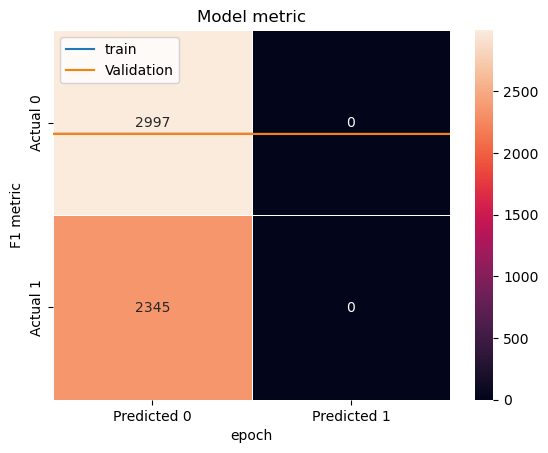

In [61]:
plt.plot(h1.history['f1_m'][1:])
plt.plot(h1.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

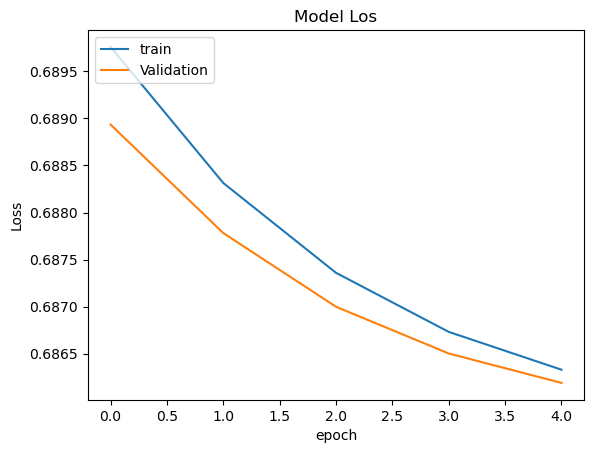

In [62]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model Los')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 2: Baseline + Sentiments

In [63]:
sentiment_model = load_model('/kaggle/input/contextmodels/sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/input/contextmodels/sentiment_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
encoded_comments_train_1 = sentiment_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv_1 = sentiment_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test_1 = sentiment_tokenizer.texts_to_sequences(test['text'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train_1, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv_1, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test_1, maxlen=140, padding='post')

In [ ]:
output_layer_sentiment = 'fully_connected'
intermediate_layer_model_1 = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train = intermediate_layer_model_1.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model_1.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model_1.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [33]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentiment_input')
concat = concatenate([dense, input_sent])

out = Dense(2, activation='softmax')(concat)

model_02 = Model(inputs=[input_data, input_sent], outputs=[out])

print(model_02.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 67, 50)       60050       embedding_2[0][0]                
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 33, 50)       0           conv1d_3[0][0]                   
____________________________________________________________________________________________

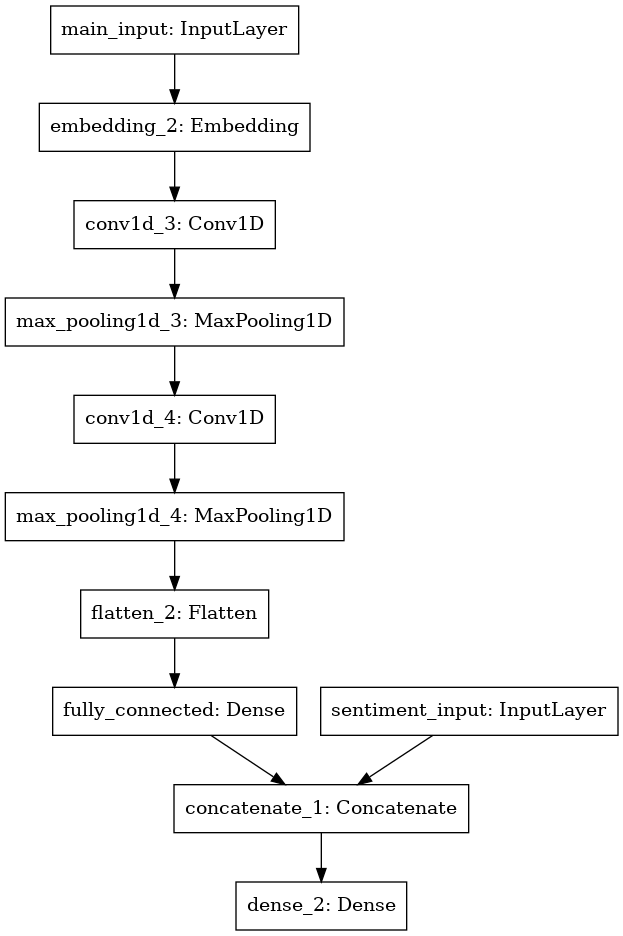

In [34]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_02, to_file='model_02.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_02')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_02.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 10,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_02.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h2 = model_02.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_2 = model_02.evaluate(X_test, y_test)
score_2

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_02.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h2.history['f1_m'][1:])
plt.plot(h2.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h2.history['loss'][1:])
plt.plot(h2.history['val_loss'][1:])
plt.title('Model Los')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 3: Baseline + Emotion_1

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_1_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles/emotion_tokenizer')

In [ ]:
encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['text'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

In [ ]:
output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [35]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_emo])

out = Dense(2, activation='softmax')(concat)

model_03 = Model(inputs=[input_data, input_emo], outputs=[out])

print(model_03.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 67, 50)       60050       embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 33, 50)       0           conv1d_5[0][0]                   
____________________________________________________________________________________________

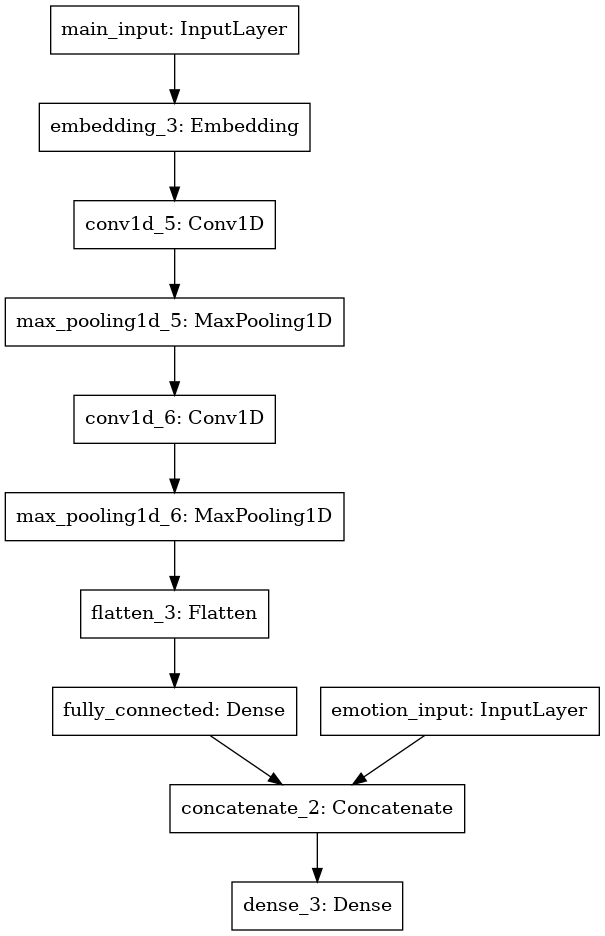

In [36]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_03, to_file='model_03.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_03')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_03.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_03.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h3 = model_03.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_3 = model_03.evaluate(X_test, y_test)
score_3

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_03.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h3.history['f1_m'][1:])
plt.plot(h3.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h3.history['loss'][1:])
plt.plot(h3.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 4: Baseline + Emotion_2

In [64]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_2_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles1/emotion_tokenizer_1')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/input/contextmodels/emotion_model_2_1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['text'])

In [ ]:
padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=300, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=300, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=300, padding='post')

In [ ]:
output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
intermediate_output_train.shape

In [37]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_emo])

out = Dense(2, activation='softmax')(concat)

model_04 = Model(inputs=[input_data, input_emo], outputs=[out])

print(model_04.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 67, 50)       60050       embedding_4[0][0]                
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 33, 50)       0           conv1d_7[0][0]                   
____________________________________________________________________________________________

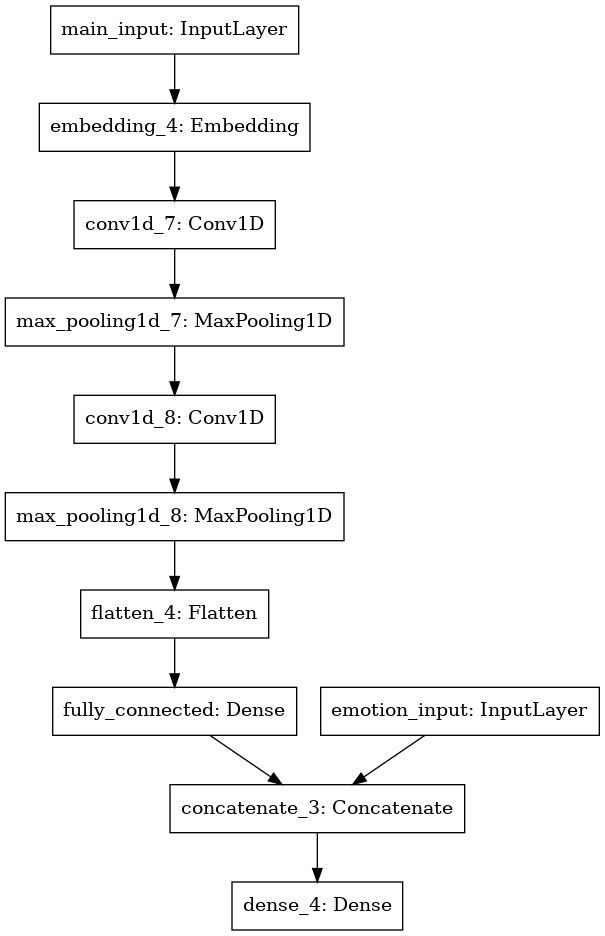

In [38]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_04, to_file='model_04.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_04')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_04.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_04.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv)]
X_test = [padded_comments_test, np.array(intermediate_output_test)]

h4 = model_04.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_4 = model_04.evaluate(X_test, y_test)
score_4

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_04.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h4.history['f1_m'][1:])
plt.plot(h4.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h4.history['loss'][1:])
plt.plot(h4.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 5: Baseline + Sentiment + Emotion_1

In [ ]:
sentiment_model = load_model('/kaggle/input/contextmodels/sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

encoded_comments_train = sentiment_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = sentiment_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = sentiment_tokenizer.texts_to_sequences(test['text'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_sentiment = 'fully_connected'
intermediate_layer_model = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train_1 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_1 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_1 = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_1_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles/emotion_tokenizer')

encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['text'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train_2 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_2 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_2 = intermediate_layer_model.predict(padded_comments_test_1)

In [39]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentimet_input')
input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_sent, input_emo])

out = Dense(2, activation='softmax')(concat)

model_05 = Model(inputs=[input_data, input_sent, input_emo], outputs=[out])

print(model_05.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 67, 50)       60050       embedding_5[0][0]                
__________________________________________________________________________________________________
max_pooling1d_9 (MaxPooling1D)  (None, 33, 50)       0           conv1d_9[0][0]                   
____________________________________________________________________________________________

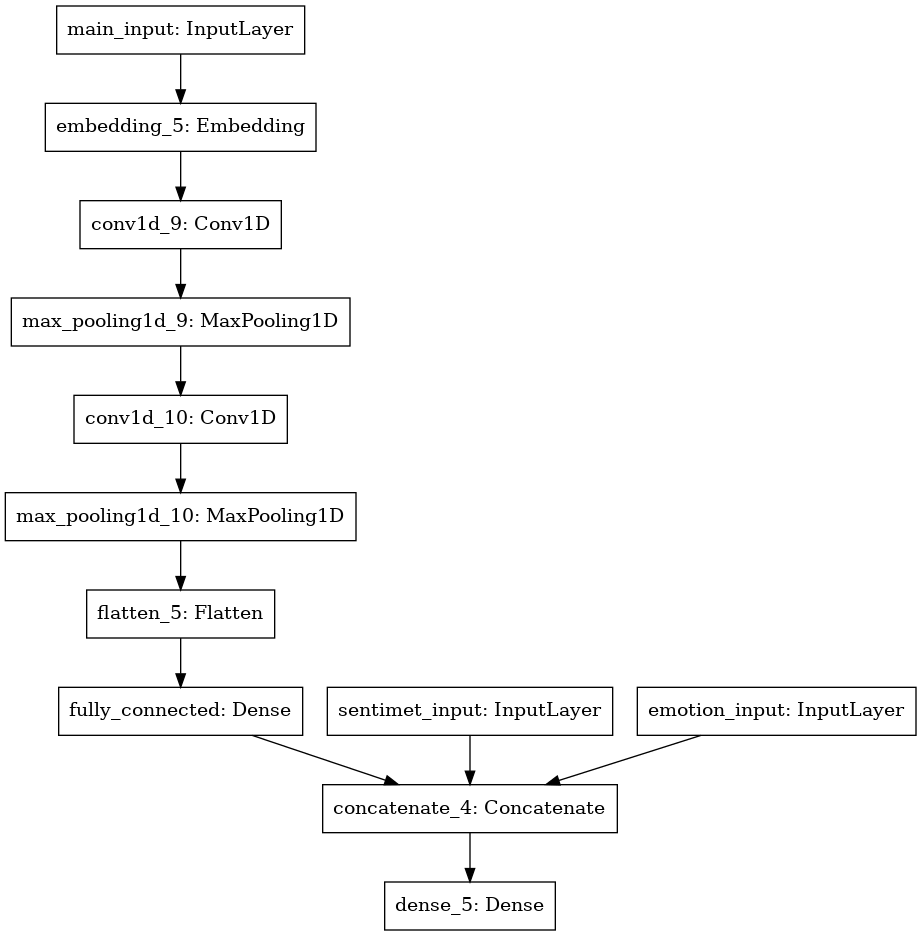

In [40]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_05, to_file='model_05.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_05')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_05.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_05.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train_1), np.array(intermediate_output_train_2)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv_1), np.array(intermediate_output_cv_2)]
X_test = [padded_comments_test, np.array(intermediate_output_test_1), np.array(intermediate_output_test_2)]

h5 = model_05.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_5 = model_05.evaluate(X_test, y_test)
score_5

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_05.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h5.history['f1_m'][1:])
plt.plot(h5.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h5.history['loss'][1:])
plt.plot(h5.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Model 6: Baseline + Sentiment + Emotion_2

In [ ]:
del w2v_model

In [ ]:
sentiment_model = load_model('/kaggle/input/contextmodels/sentiment_model.h5', custom_objects={'f1_m': f1_m})
sentiment_tokenizer = openfromfile('/kaggle/input/pickles/sentiment_tokenizer')

encoded_comments_train = sentiment_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = sentiment_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = sentiment_tokenizer.texts_to_sequences(test['text'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=140, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=140, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=140, padding='post')

output_layer_sentiment = 'fully_connected'
intermediate_layer_model = Model(inputs=sentiment_model.input, outputs=sentiment_model.get_layer(output_layer_sentiment).output)
intermediate_output_train_1 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_1 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_1 = intermediate_layer_model.predict(padded_comments_test_1)

In [ ]:
emotion_model = load_model('/kaggle/input/contextmodels/emotion_model_2_1.h5', custom_objects={'f1_m': f1_m})
emotion_tokenizer = openfromfile('/kaggle/input/pickles1/emotion_tokenizer_1')

encoded_comments_train = emotion_tokenizer.texts_to_sequences(train['text'])
encoded_comments_cv = emotion_tokenizer.texts_to_sequences(cv['text'])
encoded_comments_test = emotion_tokenizer.texts_to_sequences(test['text'])

padded_comments_train_1 = pad_sequences(encoded_comments_train, maxlen=300, padding='post')
padded_comments_cv_1 = pad_sequences(encoded_comments_cv, maxlen=300, padding='post')
padded_comments_test_1 = pad_sequences(encoded_comments_test, maxlen=300, padding='post')

output_layer_emotion = 'fully_connected'
intermediate_layer_model = Model(inputs=emotion_model.input, outputs=emotion_model.get_layer(output_layer_emotion).output)
intermediate_output_train_2 = intermediate_layer_model.predict(padded_comments_train_1)
intermediate_output_cv_2 = intermediate_layer_model.predict(padded_comments_cv_1)
intermediate_output_test_2 = intermediate_layer_model.predict(padded_comments_test_1)

In [41]:
input_data = Input(shape=(max_length,), name='main_input')
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix_w2v], trainable=False)(input_data)
conv_1 = Conv1D(filters=50, kernel_size=4, activation='relu')(embedding_layer)
max_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=100, kernel_size=3, activation='relu')(max_1)
max_2 = MaxPooling1D(pool_size=2)(conv_2)
flatten = Flatten()(max_2)
dense = Dense(100, activation='relu', name='fully_connected')(flatten)

input_sent = Input(shape=(100,), name='sentimet_input')
input_emo = Input(shape=(150,), name='emotion_input')
concat = concatenate([dense, input_sent, input_emo])

out = Dense(2, activation='softmax')(concat)

model_06 = Model(inputs=[input_data, input_sent, input_emo], outputs=[out])

print(model_06.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 70, 300)      41632500    main_input[0][0]                 
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 67, 50)       60050       embedding_6[0][0]                
__________________________________________________________________________________________________
max_pooling1d_11 (MaxPooling1D) (None, 33, 50)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [ ]:
keras.utils.vis_utils.pydot = pyd
plot_model(model_06, to_file='model_06.png')

In [ ]:
tensorboard = TensorBoard(log_dir='model_06')

reduce_lr = ReduceLROnPlateau(monitor='val_f1_m', 
                              mode = 'max', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.0001, 
                              verbose=10)

checkpoint = ModelCheckpoint("model_06.h5", 
                               monitor="val_f1_m", 
                               mode="max", 
                               save_best_only = True, 
                               verbose=1)

earlystop = EarlyStopping(monitor = 'val_f1_m', 
                            mode="max", 
                            min_delta = 0, 
                            patience = 5,
                            verbose=1)

In [ ]:
c = optimizers.Adam(lr = 0.0001)
model_06.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

X_train = [padded_comments_train, np.array(intermediate_output_train_1), np.array(intermediate_output_train_2)]
X_cv = [padded_comments_cv, np.array(intermediate_output_cv_1), np.array(intermediate_output_cv_2)]
X_test = [padded_comments_test, np.array(intermediate_output_test_1), np.array(intermediate_output_test_2)]

h6 = model_06.fit(X_train, y_train, 
               batch_size=64, 
               epochs=50, 
               verbose=1, callbacks=[tensorboard, checkpoint, earlystop, reduce_lr], 
               validation_data=(X_cv, y_cv))

In [ ]:
score_6 = model_06.evaluate(X_test, y_test)
score_6

In [ ]:
cnf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_06.predict(X_test), axis=1))

print(cnf_mat)
sns.heatmap(cnf_mat, annot=True, fmt='g', linewidths=.5, xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])

In [ ]:
plt.plot(h6.history['f1_m'][1:])
plt.plot(h6.history['val_f1_m'][1:])
plt.title('Model metric')
plt.ylabel('F1 metric')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(h6.history['loss'][1:])
plt.plot(h6.history['val_loss'][1:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.show()

## Conclusions

In [6]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Model', 'F1-Score', '% of sarcastic comments correcly classified']
x.add_row(['1', '0.7234', '73.58'])
x.add_row(['2', '0.7179', '71.78'])
x.add_row(['3', '0.7242', '71.75'])
x.add_row(['4', '0.7235', '72.07'])
x.add_row(['5', '0.7222', '70.71'])
x.add_row(['6', '0.7215', '72.10'])

In [7]:
print(x)

+-------+----------+---------------------------------------------+
| Model | F1-Score | % of sarcastic comments correcly classified |
+-------+----------+---------------------------------------------+
|   1   |  0.7234  |                    73.58                    |
|   2   |  0.7179  |                    71.78                    |
|   3   |  0.7242  |                    71.75                    |
|   4   |  0.7235  |                    72.07                    |
|   5   |  0.7222  |                    70.71                    |
|   6   |  0.7215  |                    72.10                    |
+-------+----------+---------------------------------------------+
